In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
!pip install gputil
!pip install psutil

In [3]:
import GPUtil as GPU
import psutil
def printmg():
  GPUs = GPU.getGPUs()
  gpu = GPUs[0]
  process = psutil.Process(os.getpid())
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printmg()

GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip


In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

In [ ]:
import zipfile
local_zip = './DIV2K_train_HR.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()


In [6]:
import zipfile
local_zip = './DIV2K_valid_HR.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [7]:
train_dir = "./DIV2K_train_HR/"
val_dir = "./DIV2K_valid_HR/"

In [8]:
BUFFER_SIZE = 128
BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image)
  input_image = tf.cast(image, tf.float32)
  return input_image

In [10]:
def resize(input_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image

In [11]:
def random_crop(input_image):
  cropped_image = tf.image.random_crop(
      input_image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [12]:
def normalize(input_image):
  input_image = (input_image / 127.5) - 1

  return input_image

In [13]:
def random_jitter(input_image):
  # resizing to 286 x 286 x 3
  hr = resize(input_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  hr = random_crop(hr)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    hr = tf.image.flip_left_right(hr)
  lr=resize(hr, 128, 128)
  return lr, hr

In [14]:
def load_image_train(image_file):
  input_image = load(image_file)
  lr, hr = random_jitter(input_image)
  hr = normalize(hr)
  lr = normalize(lr)
  return lr, hr

In [ ]:
train_dataset = tf.data.Dataset.list_files(train_dir+'*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [15]:
val_dataset = tf.data.Dataset.list_files(val_dir+'*.png')
val_dataset = val_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [16]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, PReLU, LeakyReLU

In [17]:
def Gen():

  inputs = tf.keras.layers.Input(shape=[128,128,3])
  initializer = tf.random_normal_initializer(0., 0.02)
  n = Conv2D(64, (3, 3), (1, 1), padding="same", kernel_initializer=initializer)(inputs)
  n = PReLU(shared_axes=[1, 2])(n)
  temp=n
  for i in range(16):
        nn = Conv2D(64, (3, 3), (1, 1), padding="same", kernel_initializer=initializer)(n)
        nn = BatchNormalization()(nn)
        nn = PReLU(shared_axes=[1, 2])(nn)
        nn = Conv2D(64, (3, 3), (1, 1), padding="same", kernel_initializer=initializer)(nn)
        nn = BatchNormalization()(nn)
        nn = tf.add(n, nn)
        n = nn

  n = Conv2D(64, (3, 3), (1, 1), padding="same", kernel_initializer=initializer)(n)
  n = BatchNormalization()(n)
  n = tf.add(n, temp)

 # n = Conv2D(256, (3, 3), (1, 1), padding="same", kernel_initializer=initializer)(n)
  #n = tf.nn.depth_to_space(n, 2)

  n = Conv2D(256, (3, 3), (1, 1), padding="same", kernel_initializer=initializer)(n)
  n = tf.nn.depth_to_space(n, 2)
  n=PReLU(shared_axes=[1, 2])(n)

  nn = Conv2D(3, (1, 1), (1, 1), activation=tf.nn.tanh, padding="same", kernel_initializer=initializer)(n)
  return tf.keras.Model(inputs=inputs, outputs=nn, name="generator")

In [20]:
generator = Gen()

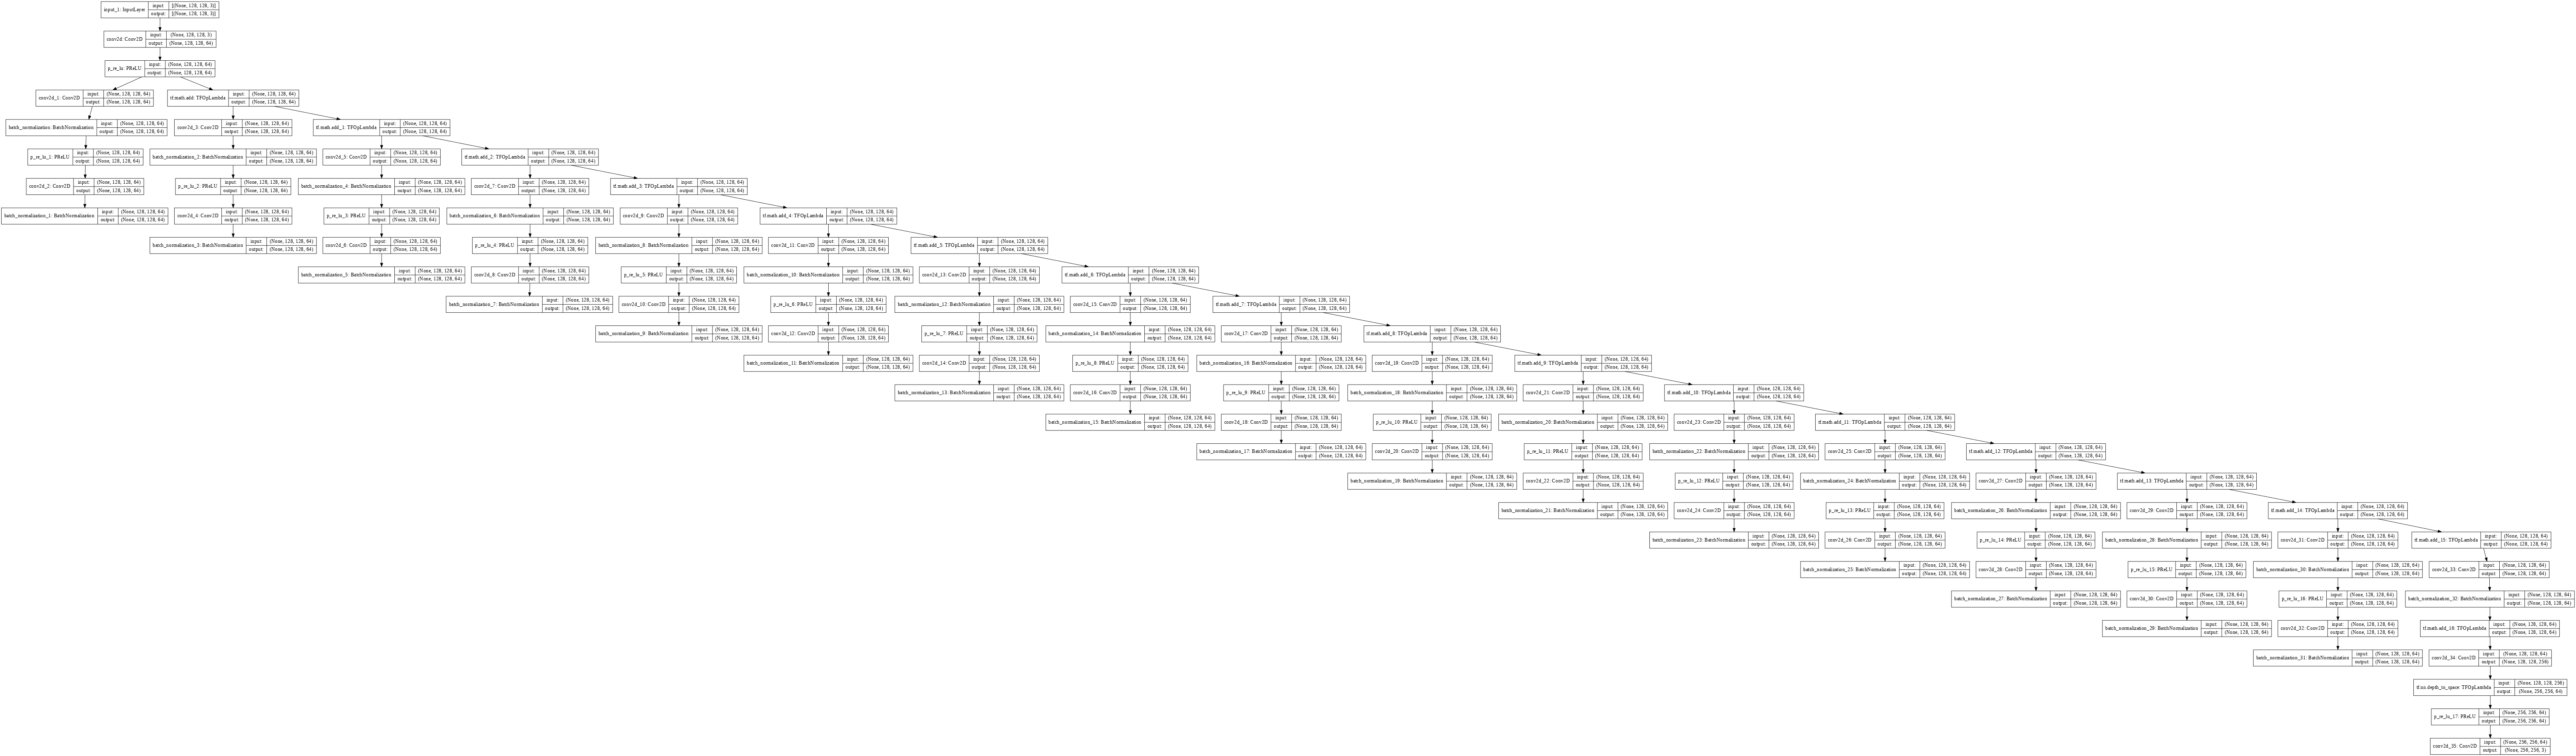

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
def Disc():
  inputs = tf.keras.layers.Input(shape=[256,256,3])
  initializer = tf.random_normal_initializer(0., 0.02)
  n = Conv2D(64, (4, 4), (2, 2), padding="same", kernel_initializer=initializer)(inputs)
  n = LeakyReLU(alpha=0.2)(n)
  n = Conv2D(64*2, (4, 4), (2, 2), padding="same", kernel_initializer=initializer)(n)
  n = BatchNormalization()(n)
  n = LeakyReLU(alpha=0.2)(n)
  n = Conv2D(64*4, (4, 4), (2, 2), padding="same", kernel_initializer=initializer)(n)
  n = BatchNormalization()(n)
  n = LeakyReLU(alpha=0.2)(n)
  n = Conv2D(64*8, (4, 4), (2, 2), padding="same", kernel_initializer=initializer)(n)
  n = BatchNormalization()(n)
  n = LeakyReLU(alpha=0.2)(n)
  n = Conv2D(64*16, (4, 4), (2, 2), padding="same", kernel_initializer=initializer)(n)
  n = BatchNormalization()(n)
  n = LeakyReLU(alpha=0.2)(n)
  n = Conv2D(64*32, (4, 4), (2, 2), padding="same", kernel_initializer=initializer)(n)
  n = BatchNormalization()(n)
  n = LeakyReLU(alpha=0.2)(n)
  n = Conv2D(64*16, (1, 1), (1, 1), padding="same", kernel_initializer=initializer)(n)
  n = BatchNormalization()(n)
  n = LeakyReLU(alpha=0.2)(n)
  n = Conv2D(64*8, (1, 1), (1, 1), padding="same", kernel_initializer=initializer)(n)
  nn = BatchNormalization()(n)
  nn = LeakyReLU(alpha=0.2)(n)

  n = Conv2D(64*2, (1, 1), (1, 1), padding="same", kernel_initializer=initializer)(nn)
  n = BatchNormalization()(n)
  n = LeakyReLU(alpha=0.2)(n)
  n = Conv2D(64*2, (3, 3), (1, 1), padding="same", kernel_initializer=initializer)(nn)
  n = BatchNormalization()(n)
  n = LeakyReLU(alpha=0.2)(n)
  n = Conv2D(64*8, (3, 3), (1, 1), padding="same", kernel_initializer=initializer)(nn)
  n = BatchNormalization()(n)
  n = tf.add(n,nn)
  n = Flatten()(n)
  n = Dense(1024)(n)
  n = LeakyReLU(alpha=0.2)(n)
  no = Dense(units=1, activation= 'sigmoid', kernel_initializer=initializer)(n)
  return tf.keras.Model(inputs=inputs, outputs=no, name="discriminator")

In [ ]:
discriminator = Disc()

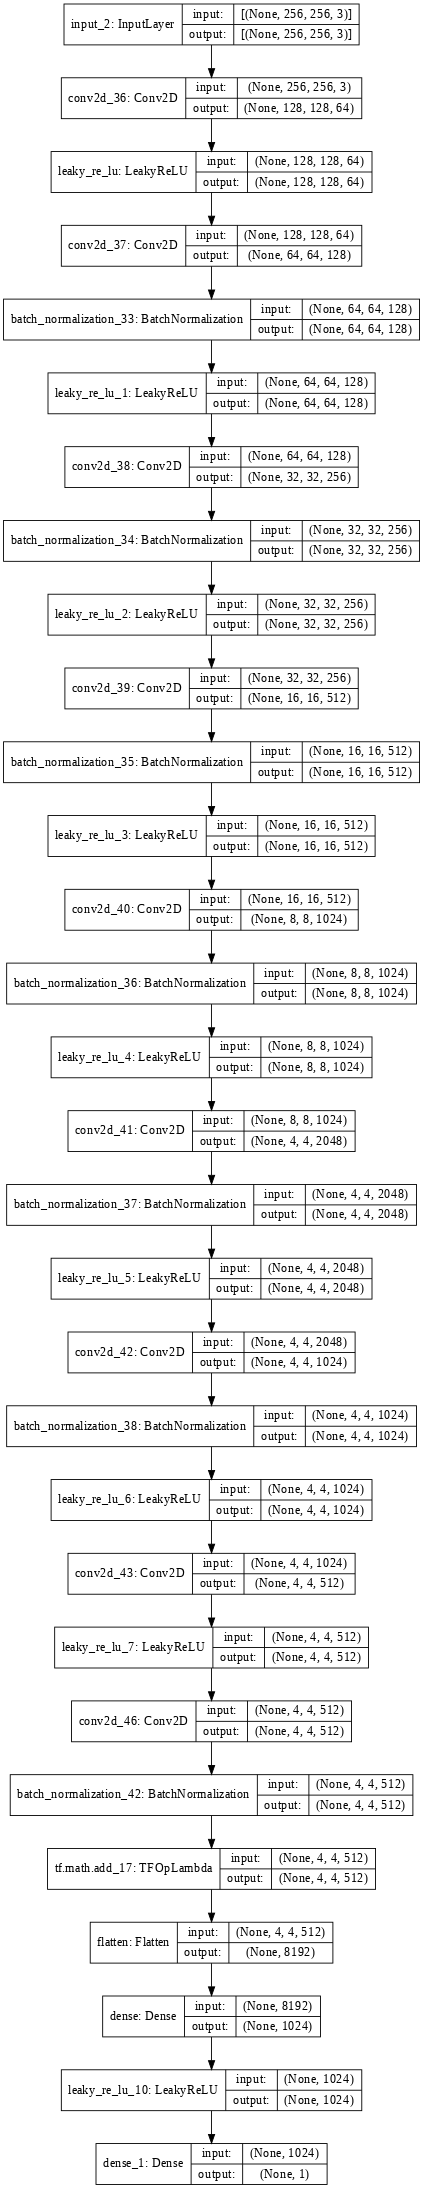

In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
from matplotlib import pyplot as plt
def generate_images(model, test_input, tar):
  prediction = model(test_input)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
VGG = tf.keras.applications.VGG19(include_top=False)


80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
def generator_loss(real,fake,disc_generated_output):
  mse = tf.reduce_mean(tf.math.squared_difference(real , fake))
  real_features = VGG(real,training=False)
  fake_features = VGG(fake,training=False)
  feature_loss = tf.reduce_mean(tf.math.squared_difference(real_features , fake_features))
  content_loss = mse + feature_loss
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  total_gen_loss = gan_loss + (100 * content_loss)
  return total_gen_loss

In [ ]:
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator(target, training=True)
    disc_generated_output = discriminator(gen_output, training=True)

    gen_total_loss = generator_loss( target,gen_output,disc_generated_output)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  return gen_total_loss, disc_loss

In [ ]:
def plotLosses(tlosses,vlosses,title1,title2,epoch):
        fig, ax1 = plt.subplots(figsize = (10,5))
        color = 'tab:blue'
        ax1.plot(tlosses,color = color, label = 'dis loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel(title1, color = color)
        ax1.tick_params('y',color = color)
        color = 'tab:green'
        ax2 = ax1.twinx()
        ax2.plot(vlosses, color = color, label = 'gen loss')
        ax2.set_ylabel(title2, color = color)
        ax2.tick_params('y', color = color)
        plt.title('training and val loss')
        plt.savefig('./drive/My Drive/SRGAN/Graphs/%d.png' % epoch)
        plt.show()

In [ ]:
from IPython import display
import time

In [ ]:
def fit(train_ds, epochs):
  train_loss=[]
  val_loss=[]
  disc_loss=[]
  for epoch in range(epochs):
    epoch+=860
    t_loss=0
    v_loss=0
    d_loss=0
    start = time.time()
    display.clear_output(wait=True)
    for example_input, example_target in val_dataset.take(1):
      generate_images(generator, example_input, example_target)

    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      g,d = train_step(input_image, target, epoch)
      d_loss+=d
      t_loss=t_loss+g
    train_loss.append(t_loss)
    disc_loss.append(d_loss)

    for n, (input_image, target) in val_dataset.enumerate():
      gen_output = generator(input_image, training=False)
      disc_generated_output = discriminator(gen_output, training=False)

      g = generator_loss( target,gen_output,disc_generated_output)
      v_loss=v_loss+g

    val_loss.append(v_loss)

    # saving the model every 10 epochs
    if (epoch + 1) % 20 == 0:                          
      plotLosses(train_loss,val_loss,'training loss', 'val loss', epoch) 
      generator.save_weights('./drive/My Drive/SRGAN/weights/GAN_gen_jpegartmediumDiv2k%d.h5' % epoch)
      discriminator.save_weights('./drive/My Drive/SRGAN/weights/GAN_dis_jpegartmediumDiv2k%d.h5' % epoch)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [23]:
# load weights
generator.load_weights('./drive/My Drive/SRGAN/weights/GAN_gen_jpegartmediumDiv2k899.h5')
discriminator.load_weights('./drive/My Drive/SRGAN/weights/GAN_dis_jpegartmediumDiv2k899.h5')

In [ ]:

EPOCHS = 300
fit(train_dataset, EPOCHS)

In [27]:

for n,(input,target) in val_dataset.enumerate():
  prediction = generator(input)
  break


In [ ]:
prediction[0]

In [ ]:
#save the result
import matplotlib.pyplot as plt
for n,(input,target) in val_dataset.enumerate():

    prediction = generator(input)
    for k in range(8):
      plt.figure(figsize=(15,5))
      display_list = [input[k], target[k], prediction[k]]
      title = ['Input Image', 'Ground Truth', 'Predicted Image']
      for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
       #getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
      plt.savefig("./drive/My Drive/SRGAN/Results/image%d.png" % n)